In [1]:
MODEL="resnext50"
NO_CONCEPTS=7
SEED=445
REDUCER="NMF"
FEATURE_TYPE="mean"
WOE_CLF="original"
ICE_CLF="logistic"
IS_TRAIN_CLF=True
THRESHOLD=0.7

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from typing import Dict, Any, Optional, Tuple
from pathlib import Path

import torch

import preprocessing.params as params
from woe.explainers import WoEExplainer

def get_paths() -> Dict[str, Path]:
    """Get paths for model files and outputs.
    
    Returns:
        Dictionary of paths
    """
    layer_name = params.ICE_CONCEPT_LAYER[MODEL]
    feature_path = Path(params.EXP_PATH) / (
        f"ICE_HAM_{MODEL}_ncomp{NO_CONCEPTS}_seed{SEED}_"
        f"{REDUCER}_{FEATURE_TYPE}_clf{IS_TRAIN_CLF}_{ICE_CLF}/feature_imgs"
    )
    evidence_path = Path(
        f"test_data/evidence/ICE_{MODEL}_ncomp{NO_CONCEPTS}_"
        f"seed{SEED}_{REDUCER}_{FEATURE_TYPE}_clf{IS_TRAIN_CLF}_"
        f"{ICE_CLF}_t{THRESHOLD}"
    )
    exp_path = Path(params.MODEL_PATH) / (
        f"ICE_Exp_{MODEL}_ncomp{NO_CONCEPTS}_seed{SEED}_"
        f"{REDUCER}_{FEATURE_TYPE}_clf{IS_TRAIN_CLF}_{ICE_CLF}.sav"
    )
    woe_path = Path(params.MODEL_PATH) / (
        f"ICE_woeexplainer_{MODEL}_ncomp{NO_CONCEPTS}_"
        f"seed{SEED}_{REDUCER}_{FEATURE_TYPE}_{WOE_CLF}.sav"
    )
    concept_path = Path(params.MODEL_PATH) / (
        f"ICE_concept_{MODEL}_ncomp{NO_CONCEPTS}_seed{SEED}_"
        f"{REDUCER}_{FEATURE_TYPE}_clf{IS_TRAIN_CLF}_{ICE_CLF}.sav"
    )

    return {
        "layer_name": layer_name,
        "feature_path": feature_path,
        "evidence_path": evidence_path,
        "exp_path": exp_path,
        "woe_path": woe_path,
        "concept_path": concept_path
    }

def load_models(paths: Dict[str, Path]) -> Tuple[WoEExplainer, Any, Any]:
    """Load required models from saved files.
    
    Args:
        paths: Dictionary of paths to model files
        
    Returns:
        Tuple of (WoE explainer, concept model, explainer)
    """
    # Load models
    explainer = torch.load(paths["exp_path"], map_location=torch.device(params.DEVICE), weights_only=False)
    woe_explainer = torch.load(paths["woe_path"], map_location=torch.device(params.DEVICE), weights_only=False)
    concept_model = torch.load(paths["concept_path"], map_location=torch.device(params.DEVICE), weights_only=False)
    
    # Update WoE explainer with additional models
    woe_explainer.concept_model = concept_model
    woe_explainer.explainer = explainer
    woe_explainer.layer_name = paths["layer_name"]
    woe_explainer.device = params.DEVICE
    
    return woe_explainer, concept_model, explainer

paths = get_paths()
woe_explainer, concept_model, explainer = load_models(paths)

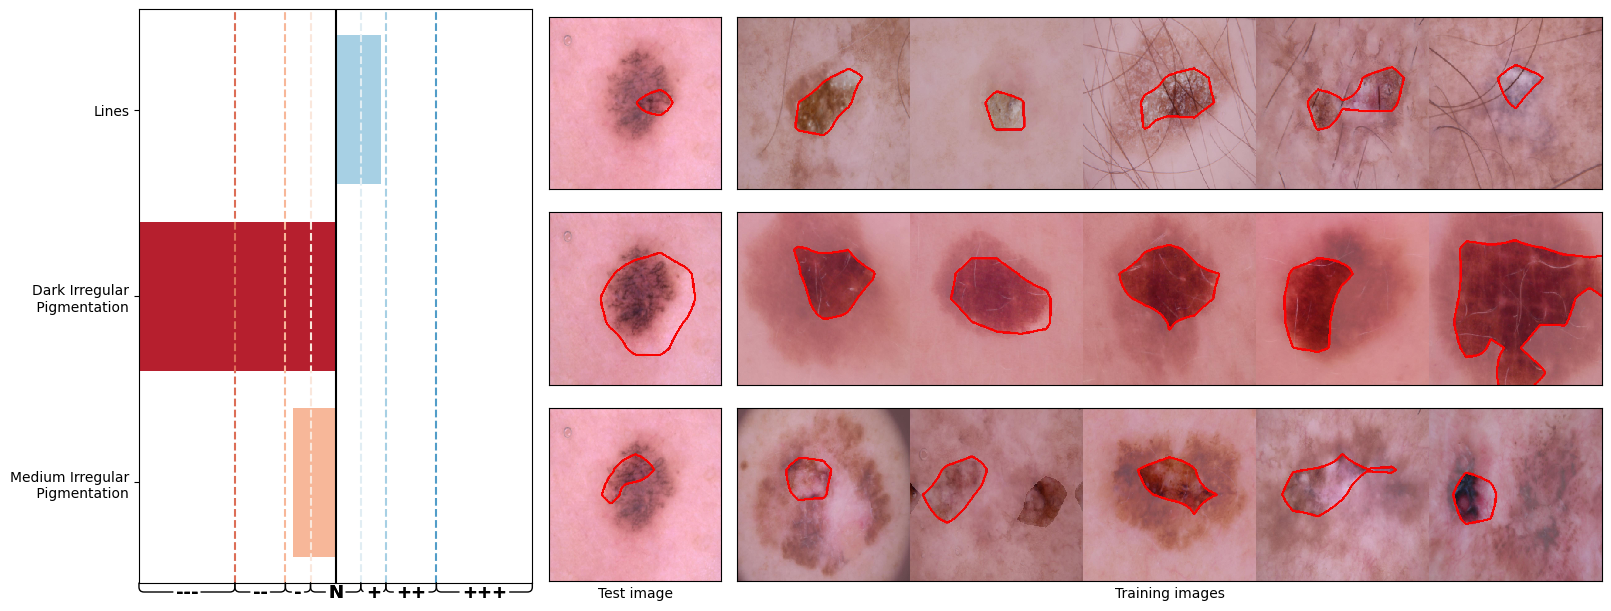

In [3]:
from utils import woe_input_image

TEST_IMAGE_PATH = Path("test_data/{}".format(SEED))

image_path = "HAM10000_images_part_2/ISIC_0031079.jpg"
img_evidence_path = paths["evidence_path"] / image_path.replace("/", "_").replace(
    ".jpg", ""
)

original_x, original_h, x_feature = woe_input_image(
    x=TEST_IMAGE_PATH / image_path,
    concept_model=concept_model,
    Exp=explainer,
    feature_type=FEATURE_TYPE,
    layer_name=params.ICE_CONCEPT_LAYER[MODEL],
)

explanation = woe_explainer.explain_for_human(
    x=x_feature,
    hypothesis=3,
    units="features",
    plot=True,
    save_path=None,
    data_type="image",
    evidence_type="all", # negative or positive or all
    img_evidence_path=img_evidence_path,
    feature_path=paths["feature_path"],
    show_significant=True,
    # save_path="example_evidence/tabular-{}.jpg".format(hypothesis_name),
)